### Create DataFrame by Attribute (Ask Garrit About Any Errors)

In [135]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

baseDir = Path('/mnt/c/Users/garri/Documents/SS2025/CIS635-DM/term-project-gjk')
dataDir = Path(baseDir / 'data')
FPMAdir = Path(dataDir / 'FPMA data')


First 5 columns used: [Ukraine, WHOLESALE, National Average, Wheat (flour, highest grade, offer, EXW), UAH/Kg], [Ukraine, WHOLESALE, National Average, Wheat (flour, first grade, offer, EXW), UAH/Kg], [Ukraine, WHOLESALE, National Average, Wheat (3rd class, bid, EXW, processing), UAH/Kg], [Ukraine, WHOLESALE, National Average, Wheat (flour, highest grade, offer, EXW), USD/Kg], [Ukraine, WHOLESALE, National Average, Wheat (flour, first grade, offer, EXW), USD/Kg].
Creating ALL_Ukraine.csv
Shape: (303, 10)


,Date,"Ukraine, WHOLESALE, National Average, Wheat (flour, highest grade, offer, EXW), UAH/Kg","Ukraine, WHOLESALE, National Average, Wheat (flour, first grade, offer, EXW), UAH/Kg","Ukraine, WHOLESALE, National Average, Wheat (3rd class, bid, EXW, processing), UAH/Kg","Ukraine, WHOLESALE, National Average, Wheat (flour, highest grade, offer, EXW), USD/Kg","Ukraine, WHOLESALE, National Average, Wheat (flour, first grade, offer, EXW), USD/Kg","Ukraine, WHOLESALE, National Average, Wheat (3rd class, bid, EXW, processing), USD/Kg","Ukraine, WHOLESALE, National Average, Wheat (flour, highest grade, offer, EXW), UAH-real/Kg","Ukraine, WHOLESALE, National Average, Wheat (flour, first grade, offer, EXW), UAH-real/Kg","Ukraine, WHOLESALE, National Average, Wheat (3rd class, bid, EXW, processing), UAH-real/Kg"
0,2000-01-01,1.14,0.960,NaN,0.21185,0.17840,NaN,3.64383,3.06849,NaN
1,2000-02-01,1.28,1.165,NaN,0.23092,0.21017,NaN,3.96062,3.60478,NaN


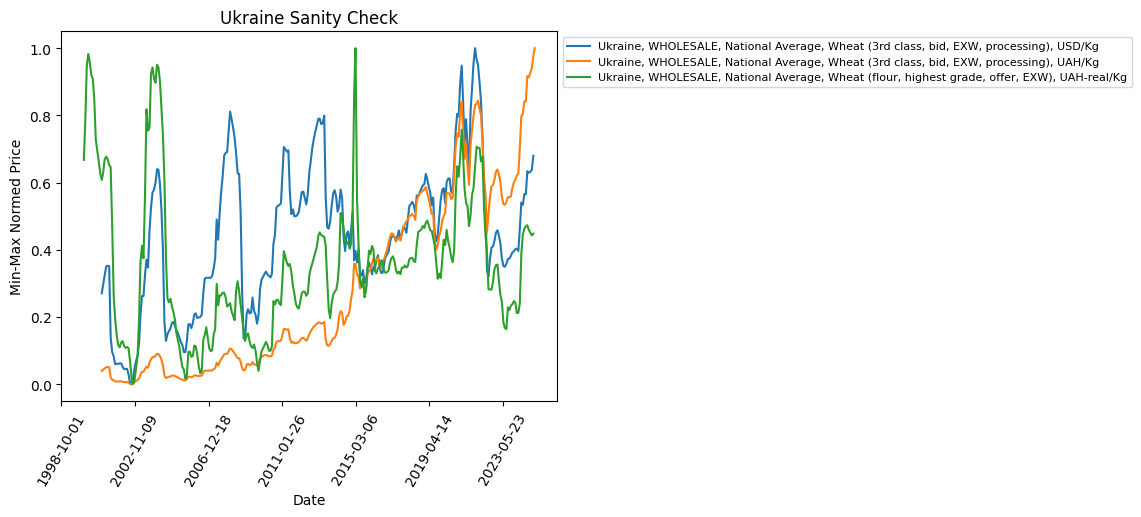

Saved.


In [166]:
def uniqueColAttributes(saveCounts = False):
	"""
	* saveCounts - leave False
	Stores each portion of column name in 'attr' dict with instance counts. 
	Returns attr - looks like:   
	{
		"countries": {
			"Bangladesh": 30,
			"Egypt": 27,
			"Indonesia": 24,
			"Lebanon": 105,
			"Libyan Arab Jamahiriya": 192,
			"Pakistan": 42,
			"Ukraine": 9,
			"INTERNATIONAL PRICES": 2
		},
		"aggregate": {
			" RETAIL": 411,
			" WHOLESALE": 18,
			" EXPORT": 2
		},
		...
	}
	Check FPMA_Attribute_Counts.json to see full output
	"""
	attr = {
		'country': {},
		'aggregate': {},
		'market': {},
		'commodity': {},
		'unit': {},
	}
	for file in FPMAdir.iterdir():
		if file.suffix == '.csv':
			df = pd.read_csv(file)
			for col in df.columns.tolist():
				colAttr = col.split(',')
				if colAttr[0] == 'Date':
					continue
				for i, key in enumerate(attr.keys()):
					if colAttr[i] not in attr[key]:
						attr[key][colAttr[i]] = 1
					else:
						attr[key][colAttr[i]] += 1

	if saveCounts:
		with open(FPMAdir / f'FPMA_Attribute_Counts.json', 'w') as file:
			json.dump(attr, file, indent=2)

	return attr

def colCombsPresent(groupBy, saveCols):
	"""
	Nests column names in lists within keys containing the values associated with groupBy values. Check any FPMAcol_groupedBy... file for example
	* Args
		* groupBy - list containing 1+ of ['country', 'aggregate', 'market', 'commodity', 'unit']
		* saveCols - save dictionary of keys like 'Indonesia, Rice' based on groupBy values with all applicable actual columns in a list within
	* Returns 
		* groups - (returns all under 'all' if empty)
	"""
	groups = {}
	attr = uniqueColAttributes()
	for file in FPMAdir.iterdir():
		if file.suffix == '.csv':
			df = pd.read_csv(file)
			for col in df.columns.tolist():
				if len(groupBy) > 0:
					groupKeyList = []
					for agg in groupBy:
						for val in attr[agg]:
							if val+',' in col or col.endswith(val):
								groupKeyList.append(val.strip())
					groupKey = ', '.join(groupKeyList)
					if groupKey not in groups:
						groups[groupKey] = [col]
					else:
						groups[groupKey].append(col)
				else:
					if 'all' not in groups and col != 'Date':
						groups['all'] = [col]
					elif col != 'Date':
						groups['all'].append(col)
		
	if saveCols:
		with open(FPMAdir / 'filteredDatasets' / f'FPMAcol_groupedBy_{"-".join(groupBy)}.json', 'w') as file:
			json.dump(groups, file, indent=2)
	
	return groups

def plotCheck(data, titleInfo):
	"""
	Randomly selects up to 3 columns and plots the self min-max normalized price over time. Meant to expose any issues with aggregation.
	* Args
		* data - output from grouping by certain attributes
		* titleInfo - list to be joined and used in title
	"""

	randCols = np.random.choice(data.columns[1:], size=3, replace=False)

	for col in randCols:
		normedPrices = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
		plt.plot(data["Date"], normedPrices, label=col)

	plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
	plt.xticks(rotation=60)
	plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

	plt.xlabel('Date')
	plt.title(f'{'-'.join(titleInfo)} Sanity Check')
	plt.ylabel('Min-Max Normed Price')
	plt.legend(fontsize=8, bbox_to_anchor=(1, 1))
	plt.show()

def getSpecificData(groupBy, saveCols = False, saveCSV = False):
	"""
	* Args
		* groupBy - 
			* dictionary like {
			* 	"commodity": "Wheat (flour)",
			* 	"country": "Indonesia"
			* }
		* saveCols - Saves the grouped columns if true (probably leave false)
		* saveCSV - Saves csv if true (probably leave true)
	* returns 
		* data - DataFrame filtered by key-value pairs provided in groupBy.
	"""

	data = pd.DataFrame()
	groupedCols = colCombsPresent(list(groupBy.keys()), saveCols)
	if 'all' in groupedCols:
		colsToUse = groupedCols['all']
	else:
		groupKey = ', '.join(groupBy.values())
		colsToUse = groupedCols[groupKey]

	print(f"First 5 columns used: [{'], ['.join(colsToUse[:5])}].")
	if saveCSV:
		print(f"Creating ALL_{'-'.join(groupBy.values())}.csv")
	
	for file in FPMAdir.iterdir():
		if file.suffix == '.csv':
			df = pd.read_csv(file)
			matchingCols = [col for col in colsToUse if col in df.columns]
			if matchingCols:
				if 'Date' not in matchingCols:
					matchingCols.insert(0, 'Date')
				data = pd.concat([data, df[matchingCols]], ignore_index=True)

	data.reset_index()
	data['Date'] = pd.to_datetime(data['Date'])
	data = data.groupby('Date', as_index=False).agg('first')
	data = data.sort_values(by='Date')

	print(f"Shape: {data.shape}")
	display(data.head(2))
	plotCheck(data, groupBy.values())

	if saveCSV:
		Path(FPMAdir / 'filteredDatasets').mkdir(exist_ok=True)
		data.to_csv(FPMAdir / 'filteredDatasets' / f"ALL_{'-'.join(groupBy.values())}.csv", index=False)
		print('Saved.')

	return data

""" Example Usage

- Check filteredDatasets/FPMA_Attribute_Counts.json for better idea of key value possibilities

data = getSpecificData({
	"commodity": "Wheat (flour)",
	"country": "Indonesia",
}, saveCols = False, saveCSV = True)
"""

data = getSpecificData({
	"country": "Ukraine"
}, saveCols = False, saveCSV = True)